# 2D Heat Equation Solver

## 🌡️ Numerical Methods for Heat Diffusion

This notebook demonstrates the implementation and comparison of two numerical methods for solving the 2D heat diffusion equation:

1. **Explicit Euler Method** - Simple but stability-limited
2. **Crank-Nicolson Method** - Implicit and unconditionally stable

### Mathematical Background

We solve the 2D heat diffusion equation:

$$\frac{\partial u}{\partial t} = \alpha \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)$$

Where:
- $u(x,y,t)$ is the temperature at point $(x,y)$ at time $t$
- $\alpha$ is the thermal diffusion coefficient

## Test of animated Plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

x = np.linspace(0, 2*np.pi, 200)
y = np.sin(x)

fig, ax = plt.subplots()
(line,) = ax.plot(x, y)

def update(frame):
    line.set_ydata(np.sin(x + frame/10))
    return (line,)

ani = FuncAnimation(fig, update, frames=100, interval=50, blit=True)
HTML(ani.to_jshtml())

In [ ]:
# Import necessary libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 🔧 Parameters and Initial Setup

In [ ]:
# Grid parameters
nx, ny = 30, 30        # Number of grid points
lx, ly = 1.0, 1.0      # Domain size
dx, dy = lx/nx, ly/ny  # Grid spacing

# Physical parameters
alpha = 0.01           # Diffusion coefficient
dt = 0.0005            # Time step
nt = 200               # Number of time steps
nts = [0, 50, 100, 150, 200] # Time steps for analysis

# Create coordinate grids for visualization
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
X, Y = np.meshgrid(x, y)

print(f"Grid resolution: {nx}×{ny}")
print(f"Domain size: {lx}×{ly}")
print(f"Grid spacing: dx={dx:.4f}, dy={dy:.4f}")
print(f"Time step: dt={dt}")
print(f"Diffusion coefficient: α={alpha}")

## 🌡️ Initial Condition: Hot Spot

In [ ]:
# Initial condition: hot spot in the middle
u0 = np.zeros((nx, ny))
u0[nx//2, ny//2] = 1.0

# Visualize initial condition
plt.figure(figsize=(8, 6))
plt.imshow(u0, origin='lower', cmap='hot', extent=[0, lx, 0, ly])
plt.colorbar(label='Temperature')
plt.title('Initial Condition: Hot Spot at Center')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 🚀 Method 1: Explicit Euler Scheme

In [ ]:
def check_cfl_condition(alpha, dt, dx, dy):
    """Check the CFL condition for stability."""
    cfl_x = alpha * dt / dx**2
    cfl_y = alpha * dt / dy**2
    if cfl_x + cfl_y > 0.5:
        print(f"Warning: CFL condition not met! (CFL_x + CFL_y = {cfl_x + cfl_y:.2f} > 0.5)")
    else:
        print(f"CFL condition met. (CFL_x + CFL_y = {cfl_x + cfl_y:.2f} ≤ 0.5)")

### Boundary Conditions for the explicit Euler scheme
Robin's boundary condition, i.e.
au+b∂n∂u​=c
   * a = 0 : Neumann boundary condition 
   * b = 0 : Dirichlet boundary condition
   * c = 0 : Homogeneous boudary condition


In [ ]:
# apply boundary conditions for explicit scheme
# a = 0 : Neumann boundary condition 
# b = 0 : Dirichlet boundary condition
# c = 0 : Homogeneous boudary condition
def heat_explicit_robin(u, dx, dy, a, b, c):
    # left boundary
    u[0,1:-1] = (dx*c + b*u[1,1:-1])/(1 + a*dx)
    # right boundary
    u[-1,1:-1] = (dx*c + b*u[-2,1:-1])/(1 + a*dx)
    # lower boundary
    u[1:-1, 0] = (dy*c + b*u[1:-1, 1])/(1 + a*dy)
    # upper boundary
    u[1:-1, -1] = (dy*c + b*u[1:-1, -2])/(1 + a*dy)
    # lower left corner
    u[0,0] = 0.5*(u[1, 0] + u[0,1])
    # lower right corner
    u[-1,0] = 0.5*(u[-2, 0] + u[-1,1])
    # upper right corner
    u[-1,-1] = 0.5*(u[-2, -1] + u[-1, -2])
    # upper left corner
    u[0,-1] = 0.5*(u[1, -1] + u[0, -2])

### One explicit Euler Step

In [ ]:
def heat_explicit_step(u, alpha, dx, dy, dt):
    """
    Perform one explicit Euler step for the 2D heat equation.
    """
    u = u.copy()
    lamx = alpha * dt / dx**2
    lamy = alpha * dt / dy**2
    un = u.copy()
    
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]
    + lamx * (un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[:-2, 1:-1])
    + lamy * (un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, :-2]))
    
    return u



# Check stability condition (CFL condition)
cfl_condition = alpha * dt * (1/dx**2 + 1/dy**2)
print(f"CFL condition: {cfl_condition:.4f} (should be ≤ 0.5 for stability)")
print(f"Method is {'STABLE' if cfl_condition <= 0.5 else 'UNSTABLE'}")

### nt explicit Euler Steps

In [ ]:
def heat_explicit(u, alpha, dx, dy, dt, nt):
    """
    Solve heat equation using explicit Euler for nt time steps.
    """
    for _ in range(nt):
        u = heat_explicit_step(u, alpha, dx, dy, dt)
    return u

## 🏗️ Method 2: Crank-Nicolson Scheme

In [ ]:
def Crank_Nicolson_matrices(alpha, dx, dy, dt):
    """
    Build the sparse matrices A and B for the Crank-Nicolson scheme.
    """
    lamx = alpha * dt / (2*dx**2)
    lamy = alpha * dt / (2*dy**2)

    # 1D second difference matrices
    ex = np.ones(nx)
    ey = np.ones(ny)
    Tx = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(nx, nx))
    Ty = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(ny, ny))

    # 2D Laplacian using Kronecker products
    Ix = eye(nx)
    Iy = eye(ny)
    L = kron(Iy, Tx)/(dx**2) + kron(Ty, Ix)/(dy**2)

    # Crank Nicolson matrices
    A = eye(nx*ny) - alpha*dt/2 * L
    B = eye(nx*ny) + alpha*dt/2 * L

    return [A, B]


In [ ]:
# Crank-Nicolson matrices with boundary conditions
# a = 0 : Dirichlet boundary condition
# b = 0 : Neumann boundary condition
# c = 0 : Homogeneous boudary condition
def Crank_Nicolson_matrices_robin(nx, ny, dx, dy, alpha, dt, a, b=0, c=0):
    """
    Erzeugt die Crank-Nicolson-Matrizen A, B für 2D-Wärmeleitung
    mit allgemeinen Robin-Randbedingungen:
        a u + b du/dn = c
    auf allen Rändern.

    Rückgabe:
        A, B, rhs_fun
    wobei rhs_fun(u) den Zusatzvektor f berechnet (wegen c).
    """
    N = nx * ny

    # Standard-Laplace-Operator mit Kronecker-Produkten
    ex = np.ones(nx)
    ey = np.ones(ny)
    Tx = diags([ex, -2*ex, ex], [-1,0,1], shape=(nx,nx))
    Ty = diags([ey, -2*ey, ey], [-1,0,1], shape=(ny,ny))

    Ix = eye(nx)
    Iy = eye(ny)
    L = kron(Iy, Tx)/(dx**2) + kron(Ty, Ix)/(dy**2)

    A = eye(N) - alpha*dt/2 * L
    B = eye(N) + alpha*dt/2 * L

    A = A.tolil()
    B = B.tolil()

    def idx(i,j):
        return j*nx + i

    # --- Randbedingungen einbauen ---
    rhs = np.zeros(N)

    # linke Kante (x=0)
    for j in range(ny):
        row = idx(0,j)
        A[row,:] = 0
        B[row,:] = 0
        A[row,row] = a - b/dx
        A[row,idx(1,j)] = b/dx
        rhs[row] = c

    # rechte Kante (x=lx)
    for j in range(ny):
        row = idx(nx-1,j)
        A[row,:] = 0
        B[row,:] = 0
        A[row,row] = a + b/dx
        A[row,idx(nx-2,j)] = -b/dx
        rhs[row] = c

    # untere Kante (y=0)
    for i in range(nx):
        row = idx(i,0)
        A[row,:] = 0
        B[row,:] = 0
        A[row,row] = a - b/dy
        A[row,idx(i,1)] = b/dy
        rhs[row] = c

    # obere Kante (y=ly)
    for i in range(nx):
        row = idx(i,ny-1)
        A[row,:] = 0
        B[row,:] = 0
        A[row,row] = a + b/dy
        A[row,idx(i,ny-2)] = -b/dy
        rhs[row] = c

    A = A.tocsr()
    B = B.tocsr()

    # kleine Hilfsfunktion für den inhomogenen Anteil
    def rhs_fun():
        return rhs.copy()

    return A, B, rhs_fun

In [ ]:
def heat_implicit_step(u, A=None, B=None):
    """
    Perform one implicit Crank-Nicolson step.
    """
    if A is None or B is None:
        # [A,B] = Crank_Nicolson_matrices(alpha, dx, dy, dt)
        [A,B, _] = Crank_Nicolson_matrices_robin(nx, ny, dx, dy, alpha, dt, 1)
    u = u.copy().reshape(-1)
    u = spsolve(A, B @ u)
    return u.reshape((nx, ny))

In [ ]:
def heat_implicit(u, alpha, dx, dy, dt, nt):
    """
    Solve heat equation using Crank-Nicolson for nt time steps.
    """
    u = u.copy().reshape(-1)
    # [A,B] = Crank_Nicolson_matrices(alpha, dx, dy, dt)
    [A,B, _] = Crank_Nicolson_matrices_robin(nx, ny, dx, dy, alpha, dt, 1)

    for n in range(nt):
        u = heat_implicit_step(u, A, B)

    return u.reshape((nx, ny))

## 📊 Example 1: Static Comparison

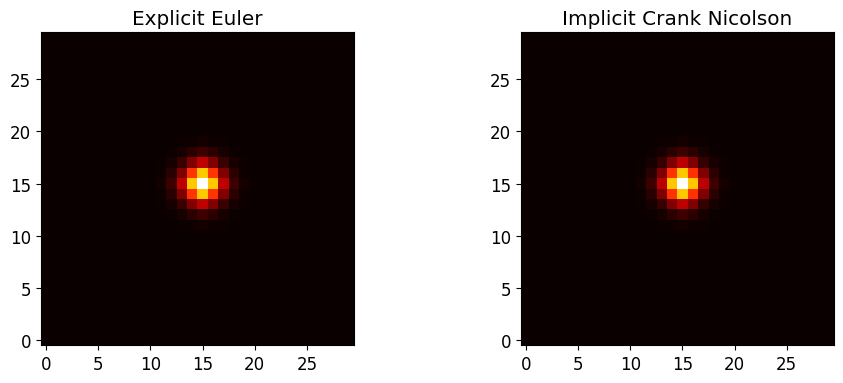

In [25]:
def example1():
    """
    Compare explicit and implicit schemes with static results.
    """
    # Run explicit and implicit schemes
    ue = heat_explicit(u0, alpha, dx, dy, dt, nt)
    ui = heat_implicit(u0, alpha, dx, dy, dt, nt)

    # Plot results
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(ue, origin="lower", cmap="hot")
    axs[0].set_title("Explicit Euler")
    axs[1].imshow(ui, origin="lower", cmap="hot")
    axs[1].set_title("Implicit Crank Nicolson")
    plt.tight_layout()
    plt.show()
    
    return ue, ui

# Run the comparison
ue_result, ui_result = example1()

## 🎬 Example 2: Animation Comparison

In [ ]:
def example2(alpha):
    """
    Create animated comparison of both methods.
    Note: Animation may not display in static notebook view.
    """
    # Prepare animation
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axs[0].imshow(u0, origin="lower", cmap="coolwarm", animated=True)
    axs[0].set_title("Heat diffusion")

    im1 = axs[1].imshow(u0, origin="lower", cmap="coolwarm", animated=True)
    axs[1].set_title("Heat diffusion")

    u = u0.copy()

    def update(frame):
        nonlocal u  # refers to u from example2 scope
        nonlocal alpha
        u = heat_explicit_step(u, alpha, dx, dy, dt)
        im0.set_array(u)
        axs[0].set_title(f"Explicit Euler. timestep {frame}")

        [A,B] = Crank_Nicolson_matrices(u, alpha, dx, dy, dt)
        u = heat_implicit_step(u, A, B)
        im1.set_array(u)
        axs[1].set_title(f"Crank Nicolson. timestep {frame}")
        return [im0, im1]

    ani = FuncAnimation(fig, update, frames=nt, interval=50, blit=False)

    return HTML(ani.to_jshtml())


## Static Comparison

In [ ]:
print("🌡️ 2D Heat Equation Solver")
print("=" * 50)
# Run static comparison
print("\n📊 Running static comparison...")
example1()

## First Animation

In [ ]:
print("\n📊 Running animation...")
example2(0.01)

## Parameter Study for different alpha

In [ ]:
print("\n🔬 Running parameter study...")
alphas_to_test = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.6]

for alpha_val in alphas_to_test:
    cfl = alpha_val * dt * (1/dx**2 + 1/dy**2)
    stability = "STABLE" if cfl <= 0.5 else "UNSTABLE"
    print(f"α = {alpha_val:5.3f}, CFL = {cfl:.4f}, Status: {stability}")

example2(0.5)
print("\n✅ Analysis complete!")

## 📝 Summary

This notebook demonstrates:

1. **Explicit Euler Method**: Simple to implement but limited by stability constraints (CFL condition)
2. **Crank-Nicolson Method**: More complex but unconditionally stable
3. **Parameter Analysis**: How different diffusion coefficients affect the solution
4. **Visualization**: Static plots and animated comparisons

### Key Takeaways:
- The CFL condition limits the time step for explicit methods
- Implicit methods can use larger time steps without stability issues
- Both methods converge to similar solutions when stable
- Animation helps visualize the time evolution of the heat diffusion process

### Next Steps:
- Experiment with different initial conditions
- Try different boundary conditions
- Compare with analytical solutions for simple cases
- Implement higher-order schemes